In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm



# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集、验证集和测试集
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)



### 自写dataset类

In [5]:
# 自定义HousingDataset类
class HousingDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        # 将NumPy数组转换为PyTorch张量
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).reshape(-1, 1)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train, y_train)
val_dataset = HousingDataset(X_val, y_val)
test_dataset = HousingDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

### 定义神经网络模型

In [6]:
# 定义神经网络模型
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# 初始化模型、损失函数和优化器
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练参数
num_epochs = 100

# 用于记录损失值
train_losses = []
val_losses = []


### 训练函数和评估函数


In [7]:
def evaluate_model(model, data_loader, criterion=None):
    """
    评估模型性能
    
    Args:
        model: 神经网络模型
        data_loader: 数据加载器
        criterion: 损失函数，如果为None则只计算MSE、RMSE和MAE
        dataset_size: 数据集大小，用于计算平均指标
        
    Returns:
        如果criterion不为None，返回平均损失
        否则返回字典，包含MSE、RMSE和MAE指标
    """
    model.eval()  # 将模型设置为评估模式，关闭dropout等训练特性
    
    if criterion is not None:
        # 计算损失
        total_loss = 0.0  # 初始化总损失为0
        with torch.no_grad():  # 关闭梯度计算，节省内存
            total_samples = 0  # 记录样本总数
            for inputs, targets in data_loader:  # 遍历数据加载器中的每个批次
                batch_size = inputs.size(0)  # 获取当前批次的样本数量
                outputs = model(inputs)  # 前向传播，获取模型预测结果
                batch_loss = criterion(outputs, targets)  # 计算当前批次的损失
                total_loss += batch_loss.item() * batch_size  # 累加加权批次损失到总损失
                total_samples += batch_size  # 累加样本数量
            
            avg_loss = total_loss / total_samples  # 计算加权平均损失
            return avg_loss  # 返回平均损失
    else:
        # 计算评估指标
        mse = 0.0  # 初始化均方误差
        total_samples = 0  # 初始化样本总数
        all_targets = []  # 存储所有真实值的列表
        all_predictions = []  # 存储所有预测值的列表
        
        with torch.no_grad():  # 关闭梯度计算
            for inputs, targets in data_loader:  # 遍历数据加载器
                batch_size = inputs.size(0)  # 获取当前批次的样本数量
                y_pred = model(inputs)  # 获取模型预测结果
                
                # 计算并累加MSE，考虑批次大小
                mse += ((y_pred - targets) ** 2).sum().item()
                # 计算并累加MAE
                total_samples += batch_size  # 累加样本数量
                
                # 收集所有预测和真实值用于绘图
                all_targets.append(targets)  # 添加当前批次的真实值
                all_predictions.append(y_pred)  # 添加当前批次的预测值
        
        # 使用实际样本数量计算平均指标，而不是预设的dataset_size
        mse /= total_samples  # 计算整个数据集的平均MSE
        
        rmse = np.sqrt(mse)  # 计算均方根误差
        
        metrics = {  # 创建包含所有评估指标的字典
            'mse': mse,  # 均方误差
            'rmse': rmse,  # 均方根误差
            'targets': torch.cat(all_targets, dim=0) if all_targets else None,  # 合并所有真实值
            'predictions': torch.cat(all_predictions, dim=0) if all_predictions else None  # 合并所有预测值
        }
        
        return metrics  # 返回评估指标字典

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """
    训练模型并记录训练和验证损失
    
    Args:
        model: 神经网络模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        
    Returns:
        train_losses: 训练损失列表
        val_losses: 验证损失列表
    """
    train_losses = []  # 初始化存储每个epoch的训练损失的列表
    val_losses = []  # 初始化存储每个epoch的验证损失的列表
    
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):  # 使用tqdm显示训练进度
        # 将模型设置为训练模式
        model.train()  # 启用dropout、batch normalization等训练特性
        
        # 训练循环
        train_loss = 0.0  # 初始化当前epoch的训练损失
        total_samples = 0  # 初始化样本计数器，用于处理最后一个batch可能较小的情况
        for inputs, targets in train_loader:  # 移除内部tqdm，只保留外部进度条
            batch_size = inputs.size(0)  # 获取当前批次的实际样本数量
            optimizer.zero_grad()  # 清除之前的梯度
            # 前向传播
            outputs = model(inputs)  # 获取模型对当前批次的预测结果
            loss = criterion(outputs, targets)  # 计算预测结果与真实值之间的损失
            
            # 反向传播和优化
            loss.backward()  # 计算损失对每个参数的梯度
            optimizer.step()  # 根据梯度更新模型参数
            
            train_loss += loss.item() * batch_size  # 累加当前批次的损失（考虑批次大小）
            total_samples += batch_size  # 累加实际处理的样本数量
        
        # 计算平均训练损失，考虑实际样本数量
        train_loss /= total_samples  # 使用实际样本数量计算平均训练损失
        train_losses.append(train_loss)  # 将当前epoch的平均训练损失添加到列表中
        
        # 计算验证损失
        val_loss = evaluate_model(model, val_loader, criterion)  # 使用验证集评估模型性能
        val_losses.append(val_loss)  # 将当前epoch的验证损失添加到列表中
        
        # 每10个epoch打印一次训练损失和验证损失
        if (epoch + 1) % 10 == 0:  # 如果当前epoch是10的倍数
            tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')  # 使用tqdm.write打印训练进度和损失
    
    return train_losses, val_losses  # 返回所有epoch的训练损失和验证损失列表


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.3255, Val Loss: 0.3231
Epoch [20/100], Train Loss: 0.2867, Val Loss: 0.3115
Epoch [30/100], Train Loss: 0.2811, Val Loss: 0.3004
Epoch [40/100], Train Loss: 0.2678, Val Loss: 0.2917
Epoch [50/100], Train Loss: 0.2657, Val Loss: 0.2952
Epoch [60/100], Train Loss: 0.2607, Val Loss: 0.2971
Epoch [70/100], Train Loss: 0.2515, Val Loss: 0.2984
Epoch [80/100], Train Loss: 0.2486, Val Loss: 0.3159
Epoch [90/100], Train Loss: 0.2832, Val Loss: 0.3114
Epoch [100/100], Train Loss: 0.2577, Val Loss: 0.3033


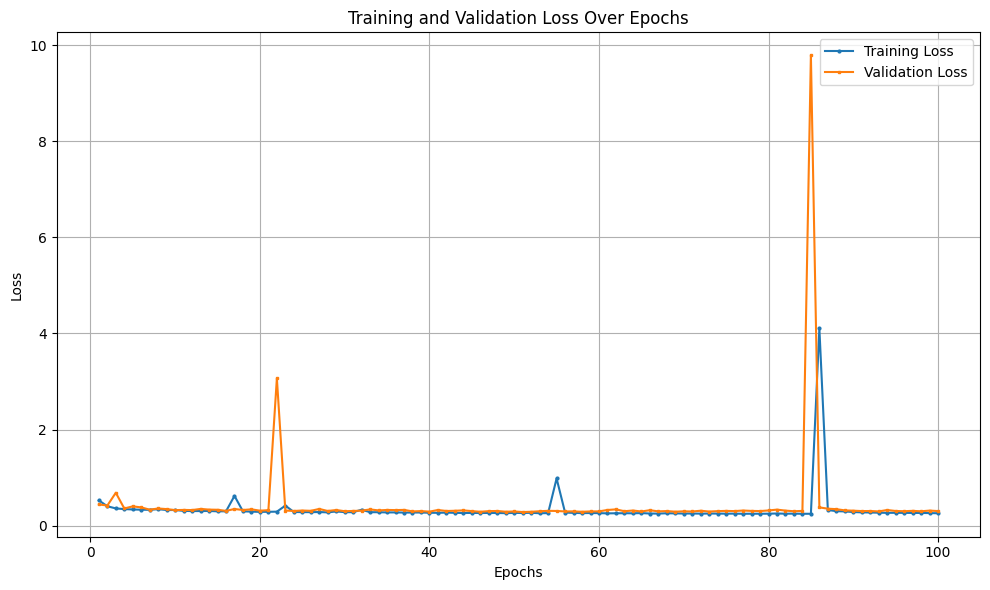

Final Training Loss: 0.2577
Final Validation Loss: 0.3033


In [9]:

# 训练模型
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# 绘制训练损失和验证损失曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o', linestyle='-', markersize=2)
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s', linestyle='-', markersize=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 打印最终的训练损失和验证损失
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
